# Working with Large Point Clouds 
This notebook will explain how use PyForestScan with large data sets. Code snippets for how to get started using PyForestScan or calculate key forest metrics can be found in the notebooks getting-started-importing-preprocessing-dtm-chm or calculate-forest-metrics, and in the documentation. 

We will use a larger section of our example data set. This section contains 2.35 billion points (20GB) with a nominal pulse spacing of 0.35 meters covering the Puuwaawaa reigion of the Big Island of Hawaii. The vegetation here is dry forest and we will clip to the same region as our other examples. This data is currently not available online but will be hosted soon on AWS. EPT data can be read directly from a URL or can be stored and read locally (it is faster to read locally).

First we will load the necessary python packages and functions.

In [1]:
import geopandas as gpd
import numpy as np

from pyforestscan.handlers import read_lidar, create_geotiff, write_las
from pyforestscan.visualize import plot_metric, plot_2d
from pyforestscan.calculate import assign_voxels, calculate_pad, calculate_pai, calculate_fhd, calculate_chm
from pyforestscan.process import process_with_tiles

## Import Data
PyForestScan leverages PDAL and Entwine to read EPT and COPC data formats. EPT and COPC are optimized for handling very large point clouds and have spatial knowlege of the data, allowing us to access metadata for the entire dataset while working with extracts. We will use this to extract only points that fit within the one kilometer tile that we explored in the other examples. 

In [5]:
bounds = ([202000.000, 203000.000], [2187999.980, 2189000.000])
ept = "../example_data/ept/ept.json"
ept_srs = "EPSG:32605"
pointclouds = read_lidar(ept, ept_srs, bounds, hag=True)

Once the file is read, we can build the voxels and calculate forest metrics:

In [6]:
voxel_resolution = (5, 5, 1) 
voxels, extent = assign_voxels(pointclouds[0], voxel_resolution)

In [7]:
pad = calculate_pad(voxels, voxel_resolution[-1])
pai = calculate_pai(pad)

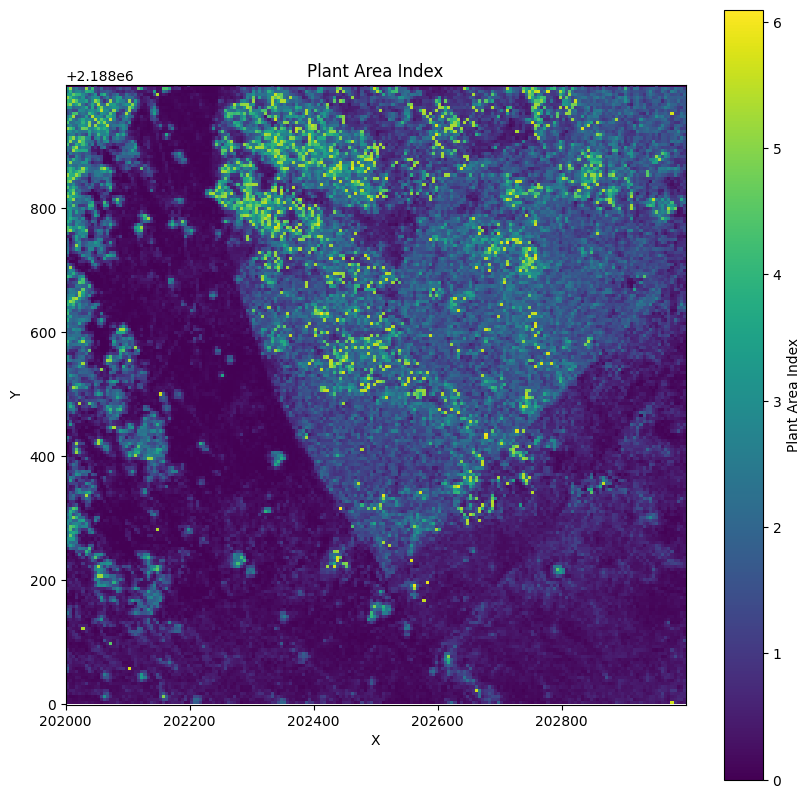

In [8]:
plot_metric("Plant Area Index", pai, extent, metric_name='Plant Area Index', cmap='viridis', fig_size=None)

## Creating Tiled Metrics

We can also read the ept file to create tiles of a given size for a given. In this example, we will read from the same EPT file to create 1000m by 1000m tiles of PAI over a larger area. It will write these tiles to a directory as geotiff files. This EPT dataset already has HeightAboveGround and so we can skip the `hag=True` argument. This will save on loading time.

In [10]:
bounds = ([202000.000, 205000.000], [2186999.980, 2190000.000])
process_with_tiles(
    ept, 
    (1000, 1000), 
    "../example_data/tiles", 
    "pai", 
    (5, 5, 1), 
    buffer_size=0.15,
    srs="EPSG:32605",
    bounds=bounds,
    hag=True
)

Processing tiles: 100%|██████████| 4/4 [00:49<00:00, 12.45s/it]

And we can plot this geotiff using rasterio or load it into a GIS.

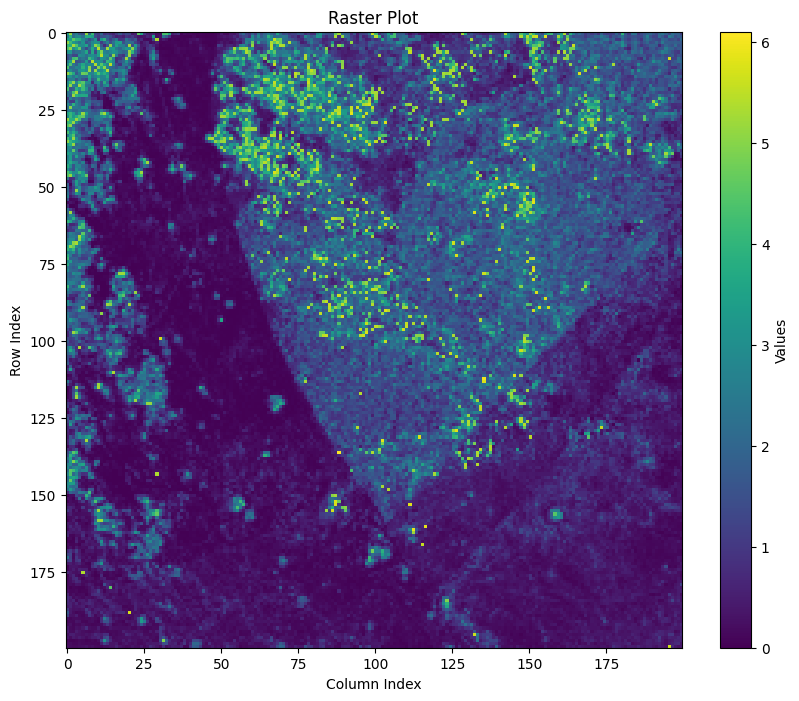

In [12]:
import rasterio
import matplotlib.pyplot as plt

tif_path = "../example_data/tiles/tile_0_0_pai.tif"

with rasterio.open(tif_path) as src:
    raster = src.read(1)
    metadata = src.meta

plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='viridis')
plt.colorbar(label="Values")
plt.title("Raster Plot")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

## Reading and Clipping to Polygons
We can also read from a large point cloud and only load the points clipped to polygons by making use of the read EPT capabilities and the ability to clip to polygons. This will also allow us to read points that belong to a single and calculate these metrics at the tree level. For example, we can calculate the PAI and FHD for a given tree.

In [20]:
crowns = gpd.read_file("../example_data/test_segment.gpkg")
crown_geom = crowns.geometry.iloc[0]
minx, miny, maxx, maxy = crown_geom.bounds
bounds = ([minx, maxx], [miny, maxy])
pointclouds = read_lidar(ept, ept_srs, bounds, crop_poly=True, poly=crown_geom.wkt)

Now to plot with points colored by height above ground:

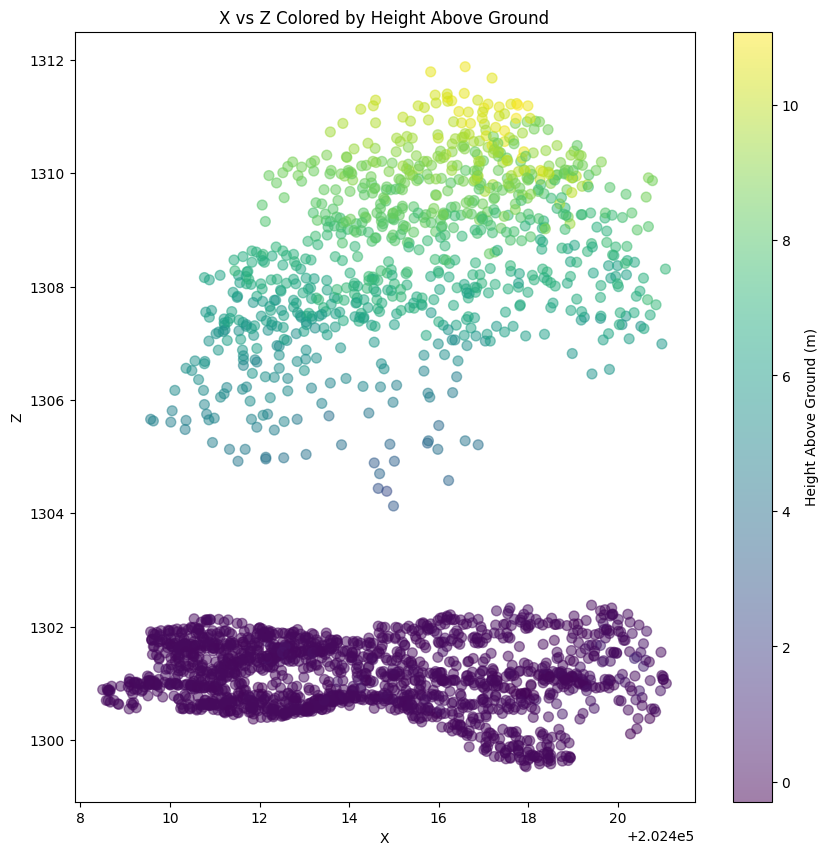

In [23]:
plot_2d(pointclouds[0], x_dim='X', y_dim='Z', alpha=0.5, point_size=50, fig_size=(10, 10))

And we can calculate metrics for the tree by setting the voxel size to be that of the bounds of the clipped point:

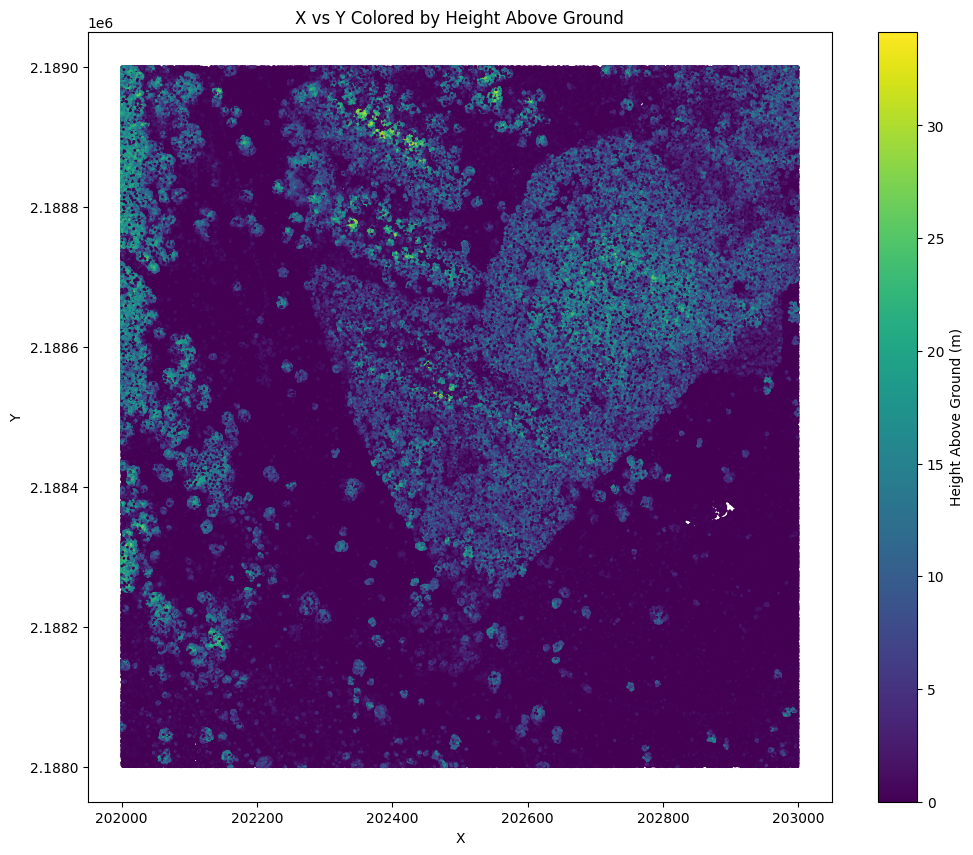

In [18]:
voxel_resolution = (maxx - minx, maxy - miny, 1) 
voxels, extent = assign_voxels(pointclouds[0], voxel_resolution)
canopy_height, extent = calculate_chm(pointclouds[0], voxel_resolution)
pad = calculate_pad(voxels, voxel_resolution[-1])
pai = calculate_pai(pad)
fhd = calculate_fhd(voxels)
print("canopy height:", canopy_height)
print("plant area index:", pai)
print("foliage height diversity:", fhd)